In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import glob
from torchvision import transforms
from torch.utils import data
from PIL import Image

In [2]:
img_dir = r'./dataset2/*.jpg'

In [3]:
imgs = glob.glob(img_dir)

In [4]:
imgs[:3]

['./dataset2\\cloudy1.jpg',
 './dataset2\\cloudy10.jpg',
 './dataset2\\cloudy100.jpg']

In [5]:
species = ['cloudy', 'rain', 'shine', 'sunrise']

In [6]:
species_to_idx = dict((c, i) for i, c in enumerate(species))

In [7]:
species_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [8]:
idx_to_species = dict((v, k) for k, v in species_to_idx.items())

In [9]:
idx_to_species

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

In [10]:
labels = []
for img in imgs:
    for i, c in enumerate(species):
        if c in img:
            labels.append(i)

In [11]:
labels[:3]

[0, 0, 0]

In [12]:
transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [13]:
class WT_dataset(data.Dataset):
    def __init__(self, imgs_path, lables):
        self.imgs_path = imgs_path
        self.lables = lables

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        lable = self.lables[index]
        
        pil_img = Image.open(img_path)
        pil_img = pil_img.convert("RGB")
        pil_img = transforms(pil_img)
        return pil_img, lable

    def __len__(self):
        return len(self.imgs_path)

In [14]:
dataset = WT_dataset(imgs, labels)

In [15]:
count = len(dataset)
print(count)

1122


In [16]:
train_count = int(0.8*count)
test_count = count - train_count
train_dataset, test_dataset = data.random_split(dataset, [train_count, test_count])
print(len(train_dataset), len(test_dataset))

897 225


In [17]:
BTACH_SIZE = 16

In [18]:
train_dl = torch.utils.data.DataLoader(
                                       train_dataset,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [19]:
test_dl = torch.utils.data.DataLoader(
                                       test_dataset,
                                       batch_size=BTACH_SIZE,
)

In [20]:
imgs, labels = next(iter(train_dl))

In [21]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [22]:
imgs[0].shape

torch.Size([3, 96, 96])

In [23]:
im = imgs[0].permute(1, 2, 0)

In [24]:
im.shape

torch.Size([96, 96, 3])

In [25]:
im = im.numpy()

In [26]:
type(im)

numpy.ndarray

In [27]:
im.shape

(96, 96, 3)

In [28]:
im.max(), im.min()

(1.0, -0.9764706)

In [29]:
im = (im + 1)/2

In [30]:
im.max(), im.min()

(1.0, 0.011764705)

Text(0.5, 1.0, 'sunrise')

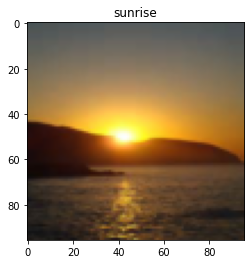

In [31]:
plt.imshow(im)
plt.title(idx_to_species[labels[0].item()])

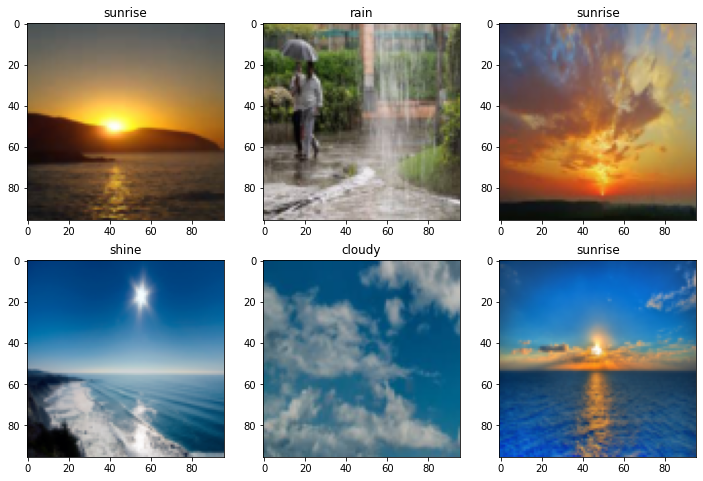

In [32]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(idx_to_species.get(label.item()))
    plt.imshow(img)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [35]:
model = Net().to(device)

In [36]:
loss_fn = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [38]:
#此处使用训练代码

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [40]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [41]:
epochs = 30

In [42]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

C:\Users\guanghua\miniconda3\envs\tch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train_loss: 0.72262, train_acc: 70.5% ,test_loss: 0.47922, test_acc: 79.6%
epoch: 1, train_loss: 0.45798, train_acc: 81.8% ,test_loss: 0.38578, test_acc: 84.4%
epoch: 2, train_loss: 0.36225, train_acc: 84.7% ,test_loss: 0.41133, test_acc: 83.6%
epoch: 3, train_loss: 0.30613, train_acc: 88.0% ,test_loss: 0.34723, test_acc: 85.8%
epoch: 4, train_loss: 0.28599, train_acc: 90.7% ,test_loss: 0.32496, test_acc: 88.0%
epoch: 5, train_loss: 0.21634, train_acc: 91.8% ,test_loss: 0.31864, test_acc: 89.8%
epoch: 6, train_loss: 0.19352, train_acc: 91.9% ,test_loss: 0.27918, test_acc: 90.7%
epoch: 7, train_loss: 0.15154, train_acc: 94.9% ,test_loss: 0.29935, test_acc: 89.8%
epoch: 8, train_loss: 0.11882, train_acc: 95.0% ,test_loss: 0.32209, test_acc: 90.2%
epoch: 9, train_loss: 0.10447, train_acc: 96.4% ,test_loss: 0.27015, test_acc: 92.4%
epoch:10, train_loss: 0.09326, train_acc: 97.3% ,test_loss: 0.33600, test_acc: 88.4%
epoch:11, train_loss: 0.06944, train_acc: 98.4% ,test_loss: 0.304

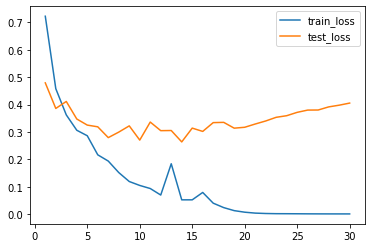

In [47]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()
plt.savefig('10-4.jpg')

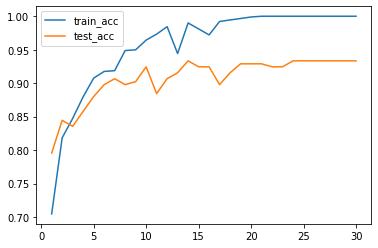

In [48]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()
plt.savefig('10-5.jpg')

# 添加dropout层

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*10*10)
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return x

In [50]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [51]:
epochs = 30

In [52]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

epoch: 0, train_loss: 0.77871, train_acc: 65.9% ,test_loss: 0.50889, test_acc: 79.1%
epoch: 1, train_loss: 0.49525, train_acc: 80.3% ,test_loss: 0.41417, test_acc: 82.2%
epoch: 2, train_loss: 0.44739, train_acc: 82.3% ,test_loss: 0.41649, test_acc: 81.3%
epoch: 3, train_loss: 0.39378, train_acc: 84.7% ,test_loss: 0.37533, test_acc: 82.2%
epoch: 4, train_loss: 0.35296, train_acc: 86.4% ,test_loss: 0.35419, test_acc: 86.2%
epoch: 5, train_loss: 0.34501, train_acc: 85.8% ,test_loss: 0.29061, test_acc: 89.3%
epoch: 6, train_loss: 0.31502, train_acc: 88.6% ,test_loss: 0.34843, test_acc: 87.6%
epoch: 7, train_loss: 0.26243, train_acc: 89.7% ,test_loss: 0.26890, test_acc: 90.7%
epoch: 8, train_loss: 0.25121, train_acc: 90.3% ,test_loss: 0.25197, test_acc: 90.2%
epoch: 9, train_loss: 0.21423, train_acc: 90.9% ,test_loss: 0.24567, test_acc: 93.3%
epoch:10, train_loss: 0.21700, train_acc: 92.2% ,test_loss: 0.24392, test_acc: 92.4%
epoch:11, train_loss: 0.15166, train_acc: 94.8% ,test_loss: 0.327

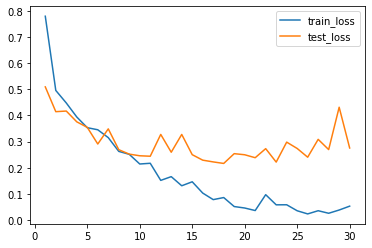

In [53]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()
plt.savefig('10-6.jpg')

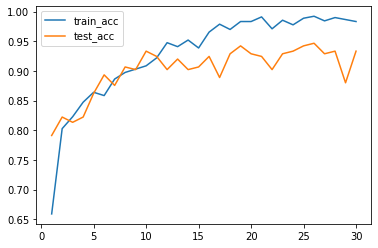

In [54]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()
plt.savefig('10-7.jpg')

# 添加BN层

In [1]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 4)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*10*10)
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
epochs = 30

In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

In [ ]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()
plt.savefig('10-8.jpg')

In [ ]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()
plt.savefig('10-9.jpg')